# Tutorial 47: Risk Parity with Risk Factors

## 1. Downloading the Data:

In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Tickers of factors

factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
factors.sort()

tickers = assets + factors
tickers.sort()

# Downloading data
data = yf.download(tickers, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers

[                       0%%                      ]

[*********************100%%**********************]  30 of 30 completed


In [23]:
# Calculating returns

X = data[factors].pct_change().dropna()
Y = data[assets].pct_change().dropna()

display(X.head())

,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,
2016-01-05,0.4735%,0.2672%,0.0000%,0.6780%,0.1634%
2016-01-06,-0.5267%,-1.1914%,-0.5380%,-0.6253%,-1.8277%
2016-01-07,-2.2293%,-2.3798%,-1.7181%,-1.6215%,-2.1609%
2016-01-08,-0.9548%,-1.1376%,-1.1978%,-1.0086%,-1.0873%
2016-01-11,0.6043%,0.1479%,-0.5898%,0.1491%,-0.6183%


## 2. Estimating Risk Parity Portfolios with Stepwise Regression

### 2.1 Estimating the loadings matrix with Stepwise Regression

In [24]:
import riskfolio as rp

feature_selection = 'stepwise' # Method to select best model, could be PCR or Stepwise
stepwise = 'Forward' # Stepwise Forward regression

loadings = rp.loadings_matrix(X=X,
                              Y=Y,
                              feature_selection=feature_selection,
                              stepwise='Forward')

In [25]:
loadings.style.format("{:.4f}").background_gradient(cmap='RdYlGn')

,const,MTUM,QUAL,SIZE,USMV,VLUE
APA,-0.0006,-0.6551,0.0000,0.9406,-0.7883,1.7237
BA,0.0005,0.0000,1.1744,0.3616,-0.4323,0.0000
BAX,0.0003,0.3146,0.0000,0.0000,0.7717,0.0000
BMY,-0.0003,0.0000,0.8123,0.0000,0.0000,0.0000
CMCSA,0.0001,0.0000,0.4958,0.0000,0.4962,0.0000
CNP,0.0001,-0.5595,-0.2157,0.0000,1.8341,0.0000
CPB,-0.0003,-0.4782,-0.5993,0.0000,2.0793,0.0000
DE,0.0004,0.0000,0.0000,0.3631,0.0000,0.8090
HPQ,0.0002,0.0000,0.0000,0.0000,0.0000,1.2514
JCI,0.0001,0.0000,0.0000,0.3412,0.0000,0.5797


### 2.2 Calculating the Factor Risk Parity Portfolio based on Market Factors

In [26]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

feature_selection = 'stepwise' # Method to select best model, could be PCR or Stepwise
stepwise = 'Forward' # Forward or Backward regression

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   feature_selection=feature_selection,
                   stepwise=stepwise,
                  )

# Estimate optimal portfolio:

model = 'FC' # Factor Contribution Model
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
b_f = None # Risk factor contribution vector

w = port.rp_optimization(model=model,
                         rm=rm,
                         rf=rf,
                         b_f=b_f,
                         )

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,3.4043%,6.7392%,12.1900%,1.7630%,4.7055%,1.3044%,3.9584%,9.1086%,2.6702%,8.1726%,...,5.5834%,-4.3732%,4.5495%,4.6024%,-4.8083%,1.6136%,9.9630%,7.0540%,-2.8460%,-0.2025%


### 2.3 Plotting Portfolio Composition

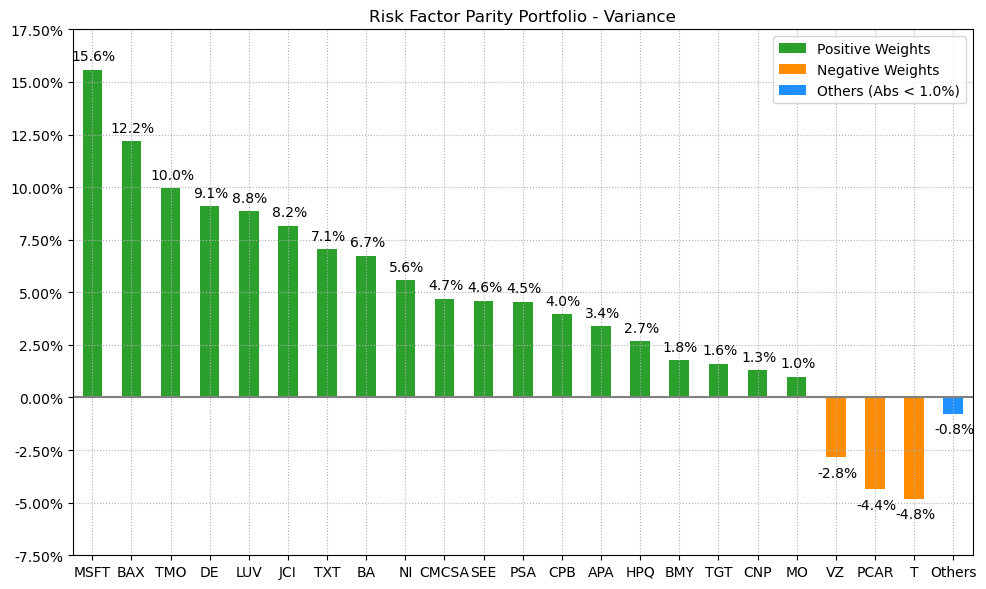

In [27]:
# Plotting the composition of the portfolio
ax = rp.plot_bar(w,
                 title='Risk Factor Parity Portfolio - Variance',
                 kind="v",
                 others=0.05,
                 nrow=25,
                 height=6,
                 width=10,
                 ax=None)

### 2.3 Calculate the Risk Contribution per Asset

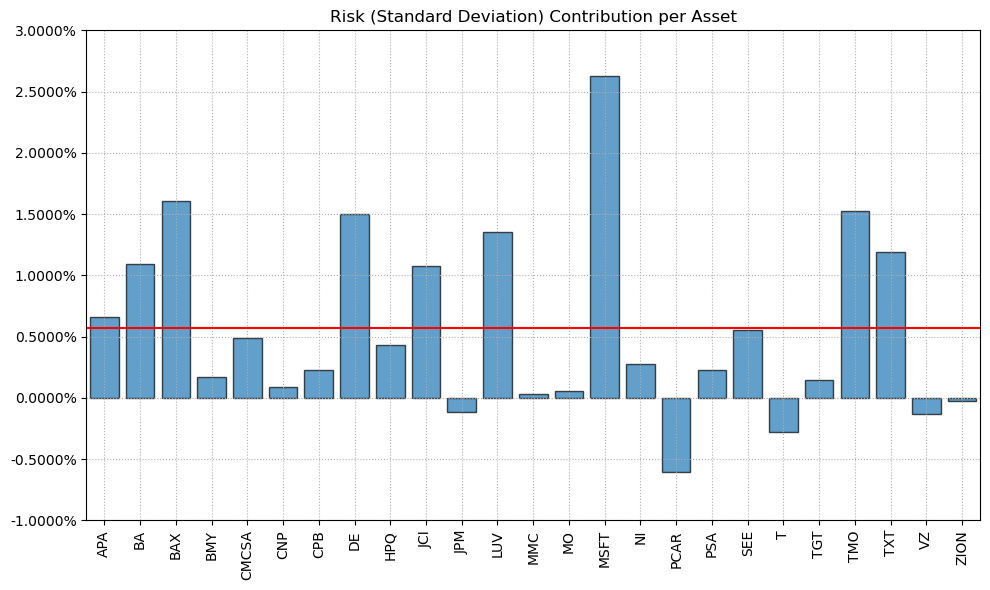

In [28]:
ax = rp.plot_risk_con(w,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      ax=None)

### 2.4 Calculate the Risk Contribution per Risk Factor

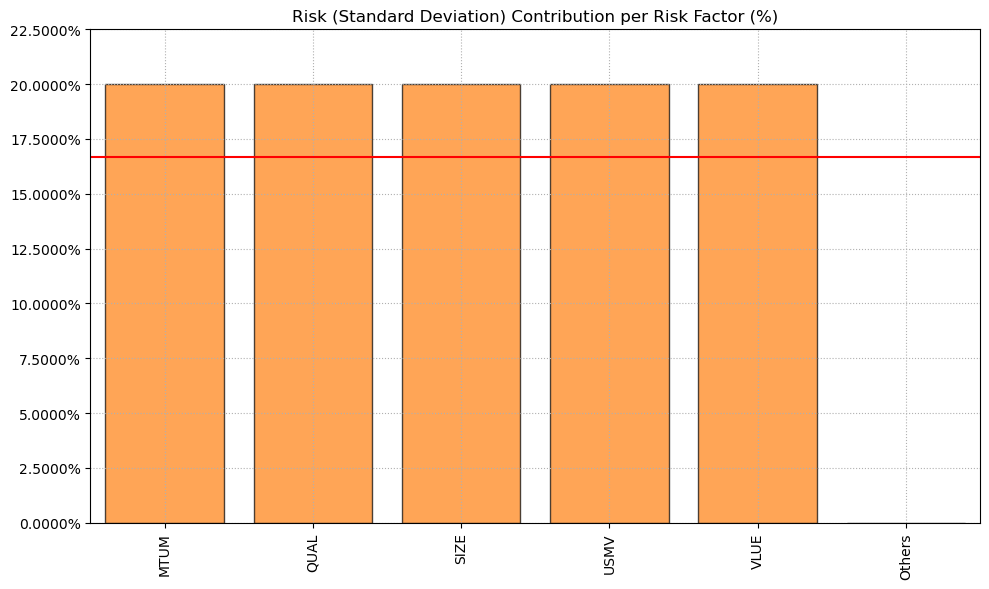

In [29]:
ax = rp.plot_factor_risk_con(
    w,
    cov=port.cov,
    returns=port.returns,
    factors=port.factors,
    rm=rm,
    rf=0,
    feature_selection=feature_selection,
    stepwise=stepwise,
    percentage=True,
    erc_line=True,
    color="tab:orange",
    ax=None,
)

## 3. Estimating Portfolios Using Risk Factors with Other Risk Measures and Stepwise Regression

### 3.1 Calculate Optimal Factor Risk Parity Portfolios based on Market Factors for Several Risk Measures

In [30]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

# When we use hist = True the risk measures all calculated
# using historical returns, while when hist = False the
# risk measures are calculated using the expected returns 
#  based on risk factor model: R = a + B * F

for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b_f=b_f)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [31]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,CDaR,UCI,EDaR
APA,3.40%,2.78%,3.63%,2.38%,3.36%,3.86%,5.31%,0.29%,0.13%,0.59%
BA,6.74%,6.67%,6.78%,6.50%,6.68%,6.69%,7.29%,5.65%,5.59%,6.10%
BAX,12.19%,11.69%,12.44%,11.59%,12.40%,12.70%,13.70%,13.38%,13.46%,13.42%
BMY,1.76%,2.16%,1.60%,2.28%,1.66%,1.35%,0.72%,1.83%,1.89%,1.94%
CMCSA,4.71%,4.83%,4.66%,4.87%,4.69%,4.58%,4.43%,5.04%,5.05%,5.11%
CNP,1.30%,1.31%,1.30%,1.25%,1.28%,1.32%,1.19%,1.09%,0.73%,0.95%
CPB,3.96%,3.63%,4.10%,3.49%,4.04%,4.31%,4.76%,4.05%,3.67%,3.87%
DE,9.11%,8.58%,9.34%,8.40%,9.23%,9.58%,10.69%,8.78%,8.84%,8.91%
HPQ,2.67%,3.04%,2.51%,3.31%,2.65%,2.39%,1.44%,3.60%,3.97%,3.36%
JCI,8.17%,7.63%,8.41%,7.42%,8.29%,8.66%,9.83%,7.73%,7.74%,7.88%


<Axes: >

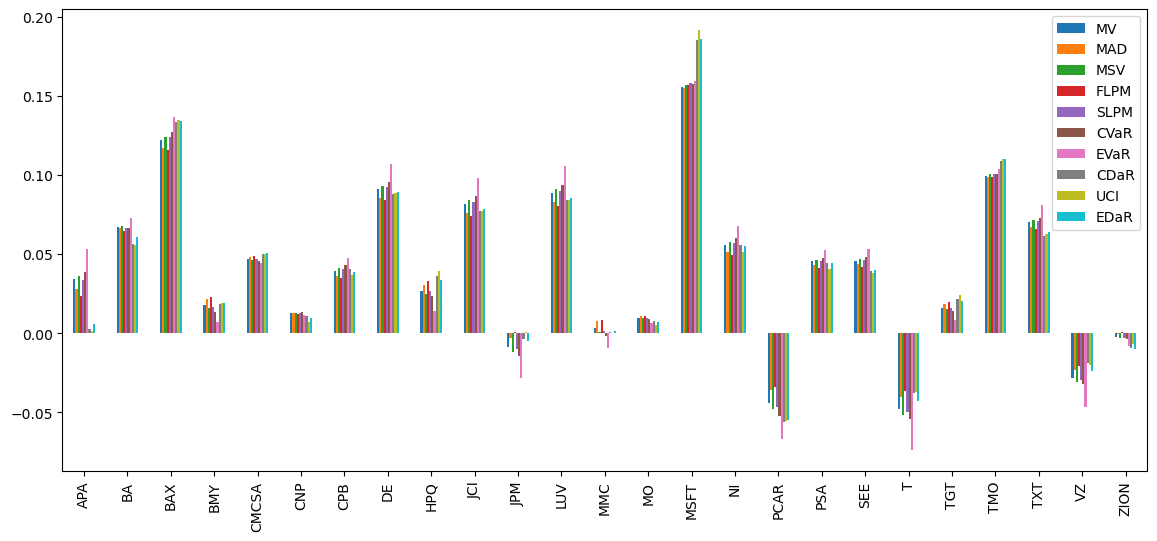

In [32]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

## 4. Estimating Risk Parity Portfolios with PCR Regression

### 4.1 Estimating the Loadings Matrix with PCR

In [33]:
feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

loadings = rp.loadings_matrix(X=X,
                              Y=Y,
                              feature_selection=feature_selection,
                              n_components=n_components)

loadings.style.format("{:.4f}").background_gradient(cmap='RdYlGn')

,const,MTUM,QUAL,SIZE,USMV,VLUE
APA,-0.0006,-0.6174,0.3847,1.0857,-1.1434,1.4537
BA,0.0005,0.2236,0.3103,0.2055,-0.0523,0.4583
BAX,0.0003,0.3086,0.1875,0.0764,0.5222,-0.0462
BMY,-0.0003,0.0716,0.1550,0.2640,0.3029,0.1028
CMCSA,0.0001,0.0825,0.1750,0.2755,0.2803,0.1424
CNP,0.0001,-0.2225,-0.0563,0.5690,1.1192,-0.4869
CPB,-0.0003,-0.2158,-0.0891,0.5280,1.1880,-0.5770
DE,0.0005,0.0756,0.3323,0.3341,-0.3697,0.7040
HPQ,0.0002,0.1799,0.3985,0.2753,-0.4645,0.8125
JCI,0.0000,-0.0535,0.2147,0.4089,-0.0640,0.4251


### 4.2 Calculating the Factor Risk Parity Portfolio based on Principal Components

In [34]:
feature_selection = 'PCR' # Method to select best model, could be PCR or Stepwise
n_components = 0.95 # 95% of explained variance. See PCA in scikit learn for more information

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   feature_selection=feature_selection,
                   n_components=n_components
                  )

# Estimate optimal portfolio:

model = 'FC' # Factor Contribution Model
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
b_f = None # Risk factor contribution vector

w = port.rp_optimization(model=model,
                         rm=rm,
                         rf=rf,
                         b_f=b_f,
                         )

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,55.8298%,33.7796%,0.3641%,-1.4934%,1.4978%,-70.1808%,-75.5607%,44.5782%,58.5467%,15.3849%,...,-97.5659%,43.9617%,-80.0300%,-12.5848%,-15.3020%,21.1252%,10.6358%,49.5090%,-50.4488%,78.7480%


### 4.3 Plotting portfolio composition

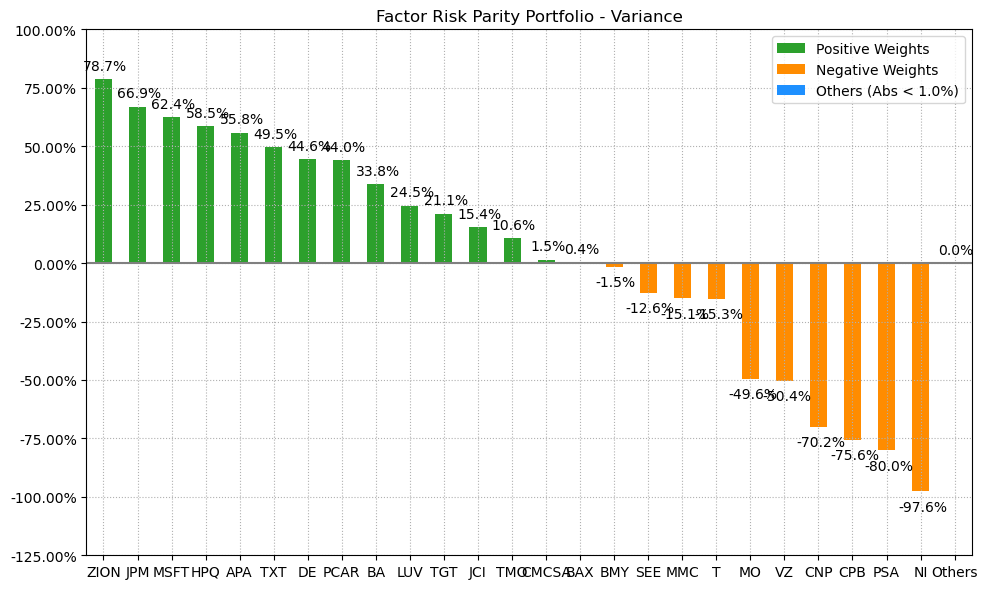

In [35]:
# Plotting the composition of the portfolio
ax = rp.plot_bar(w,
                 title='Factor Risk Parity Portfolio - Variance',
                 kind="v",
                 others=0.05,
                 nrow=25,
                 height=6,
                 width=10,
                 ax=None)

### 4.4 Calculate the risk contribution per asset

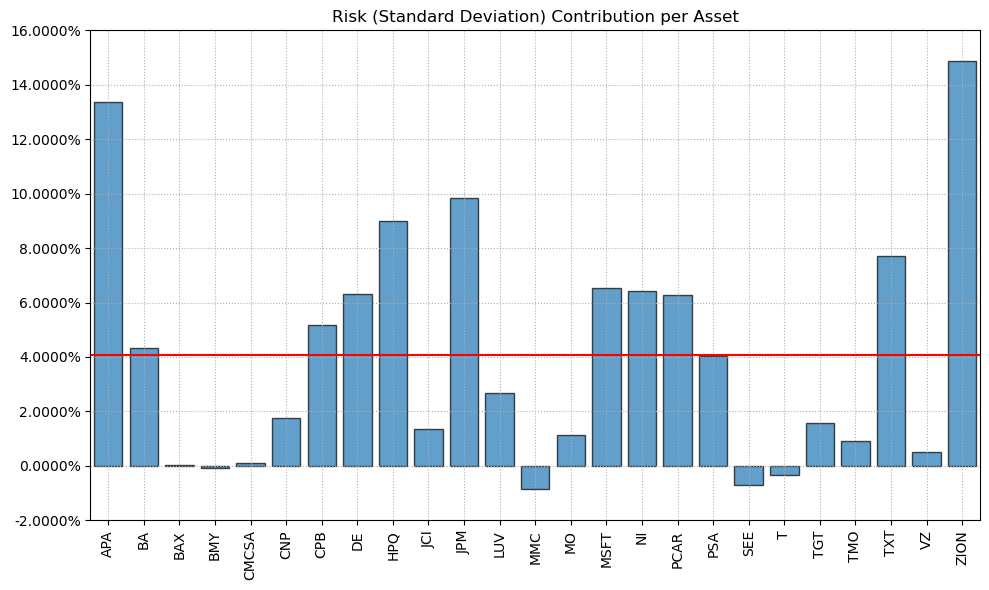

In [36]:
ax = rp.plot_risk_con(w,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      ax=None)

### 4.5 Calculate the risk contribution per principal component

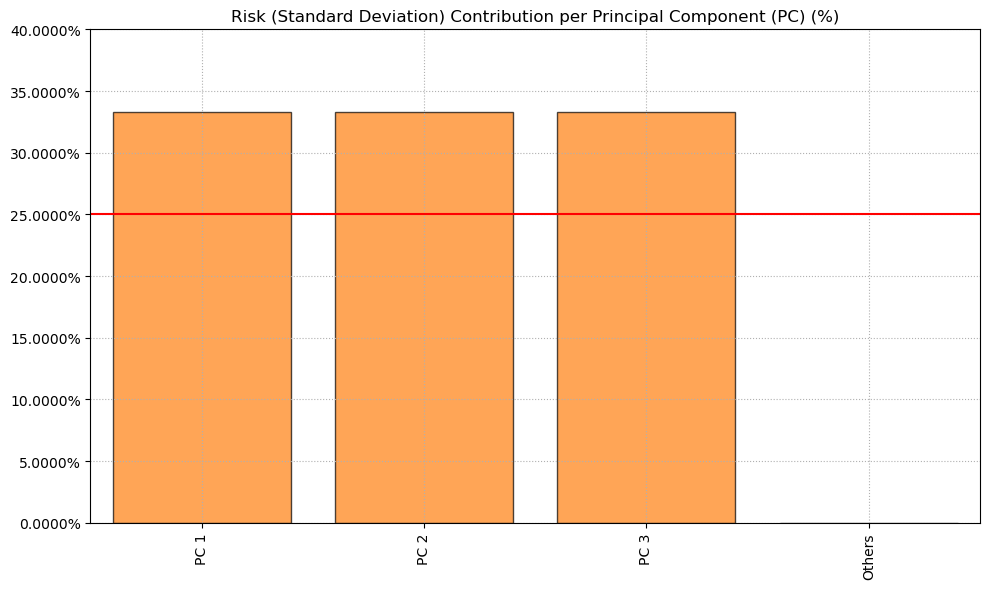

In [37]:
ax = rp.plot_factor_risk_con(
    w,
    cov=port.cov,
    returns=port.returns,
    factors=port.factors,
    rm=rm,
    rf=0,
    feature_selection=feature_selection,
    stepwise=stepwise,
    percentage=True,
    erc_line=True,
    color="tab:orange",
    ax=None,
)

## 5. Estimating Portfolios Using Risk Factors with Other Risk Measures and PCR

### 5.1 Calculate Optimal Factor Risk Parity Portfolios based on Principal Components for Several Risk Measures.

In [38]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

# When we use hist = True the risk measures all calculated
# using historical returns, while when hist = False the
# risk measures are calculated using the expected returns 
#  based on risk factor model: R = a + B * F

for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b_f=b_f)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [39]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,CDaR,UCI,EDaR
APA,55.83%,35.73%,90.95%,20.43%,62.93%,451.46%,-175.95%,0.01%,0.53%,6.99%
BA,33.78%,25.23%,49.69%,22.05%,42.15%,269.25%,-77.21%,24.92%,12.89%,47.43%
BAX,0.36%,3.23%,-4.20%,6.93%,1.79%,-25.33%,27.74%,15.12%,9.45%,23.06%
BMY,-1.49%,0.59%,-5.11%,2.24%,-2.13%,-41.15%,22.26%,4.57%,4.28%,4.23%
CMCSA,1.50%,2.72%,-0.54%,3.97%,1.58%,-16.10%,14.40%,6.32%,5.11%,7.77%
CNP,-70.18%,-46.70%,-113.09%,-35.22%,-88.79%,-662.12%,224.61%,-33.66%,-10.65%,-79.52%
CPB,-75.56%,-50.38%,-121.54%,-37.91%,-95.28%,-707.31%,240.03%,-35.70%,-11.59%,-83.98%
DE,44.58%,31.60%,68.21%,24.95%,54.38%,365.59%,-117.22%,23.03%,11.43%,46.58%
HPQ,58.55%,41.62%,89.53%,33.50%,72.21%,488.42%,-154.55%,32.91%,15.75%,66.88%
JCI,15.38%,11.27%,22.73%,8.64%,17.65%,106.66%,-33.99%,6.21%,4.46%,10.62%


<Axes: >

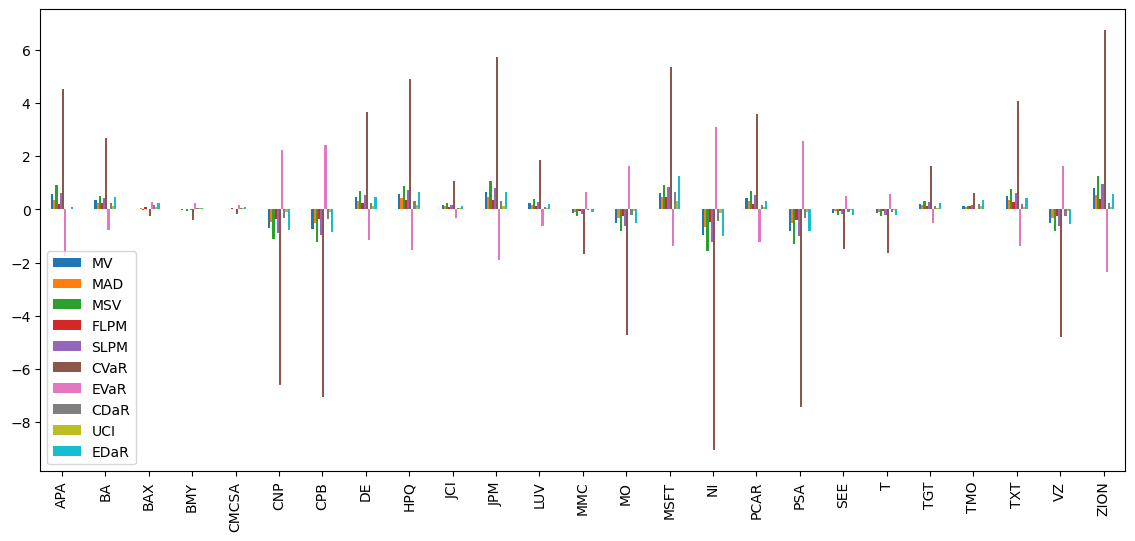

In [40]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)